In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## Explore the data

In [15]:
esc50_csv = '../data/ESC-50-master/meta/esc50.csv'
data_path = '../data/ESC-50-master/audio/'

df = pd.read_csv(esc50_csv)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [16]:
map_class_to_id = {'car_horn':1, 'siren':2}

class_id = df['category'].apply(lambda name: map_class_to_id[name] if name in map_class_to_id.keys() else 0)
df = df.assign(target=class_id)

full_path = df['filename'].apply(lambda row: os.path.join(data_path, row))
df = df.assign(filename=full_path)

df.head(10)

,filename,fold,target,category,esc10,src_file,take
0,../data/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
1,../data/ESC-50-master/audio/1-100038-A-14.wav,1,0,chirping_birds,False,100038,A
2,../data/ESC-50-master/audio/1-100210-A-36.wav,1,0,vacuum_cleaner,False,100210,A
3,../data/ESC-50-master/audio/1-100210-B-36.wav,1,0,vacuum_cleaner,False,100210,B
4,../data/ESC-50-master/audio/1-101296-A-19.wav,1,0,thunderstorm,False,101296,A
5,../data/ESC-50-master/audio/1-101296-B-19.wav,1,0,thunderstorm,False,101296,B
6,../data/ESC-50-master/audio/1-101336-A-30.wav,1,0,door_wood_knock,False,101336,A
7,../data/ESC-50-master/audio/1-101404-A-34.wav,1,0,can_opening,False,101404,A
8,../data/ESC-50-master/audio/1-103298-A-9.wav,1,0,crow,False,103298,A
9,../data/ESC-50-master/audio/1-103995-A-30.wav,1,0,door_wood_knock,False,103995,A


In [11]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=4000)
    print(tf.shape(wav))
    return wav

tf.Tensor([20000], shape=(1,), dtype=int32)


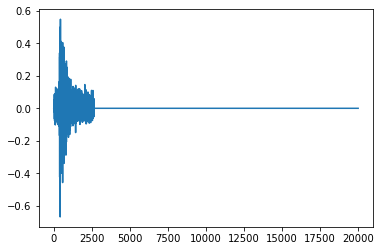

In [35]:
testing_wav_data = load_wav_16k_mono(df[df['target']==1].iloc[0,0])

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=4000)

## Datasets

In [6]:
filenames = df['filename']
targets = df['target']
folds = df['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

In [7]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)

Tensor("Shape_1:0", shape=(None,), dtype=int32)


In [8]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda filename, target, fold: fold < 4)
val_ds = cached_ds.filter(lambda filename, target, fold: fold == 4)
test_ds = cached_ds.filter(lambda filename, target, fold: fold == 5)

remove_fold_column = lambda filenames, label, fold: (filenames, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)